In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os

In [3]:
parent_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(parent_dir)

In [4]:
from src import model as hp
from src import utils

In [5]:
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
n_series = 10
n_years = 3

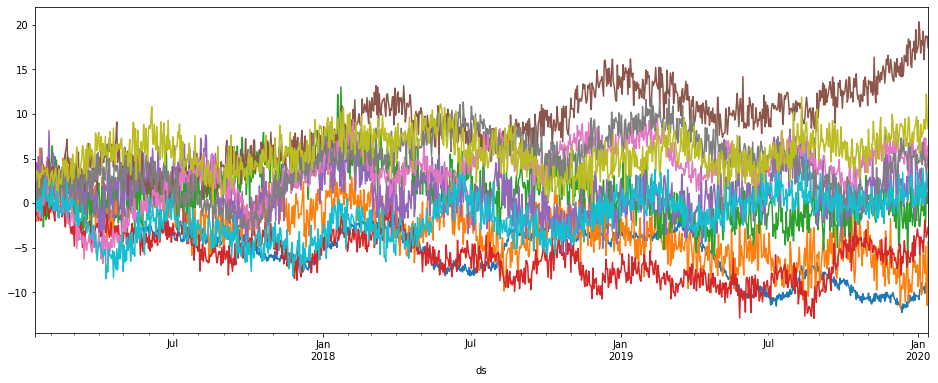

In [19]:
df = utils.random_timeseries(n_series=n_series, n_years=n_years, equal_trend=False).set_index('ds')
df.drop(columns=['t']).plot(legend=False, figsize=(16,6))

In [20]:
prophet = hp.HierarchicalProphet(trend_hierarchical=True, seasonality_hierarchical=True)
prophet.fit(df)

logp = 13,362, ||grad|| = 104.95: : 5001it [01:30, 55.43it/s]                         



In [21]:
n = 3000

t = np.arange(n)
df_fit = prophet.sample(t, past_uncertainty=False)
quantiles = prophet.empirical_quantiles(t)

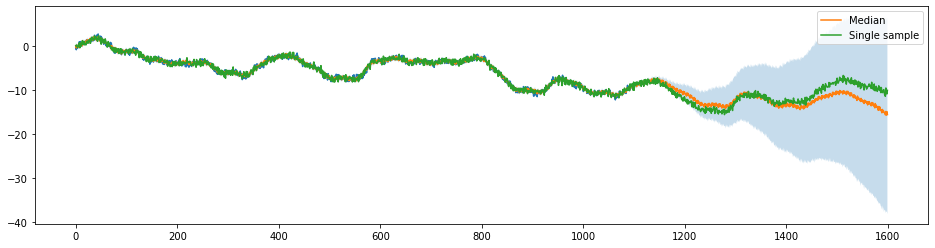

In [22]:
idx_series = 0
n_plot = 1600

df_sample = prophet.sample(t, past_uncertainty=True)

plt.figure(figsize=(16, 4))
plt.plot(df['t'][:n_plot], df.iloc[:n_plot, idx_series + 1])
plt.plot(df_fit['t'][:n_plot], quantiles[1, :n_plot, idx_series], label = 'Median')
plt.plot(df_sample['t'][:n_plot], df_sample.iloc[:n_plot, idx_series + 1], label='Single sample')
plt.fill_between(df_fit['t'][:n_plot], quantiles[0, :n_plot, idx_series], 
                 quantiles[2, :n_plot, idx_series], alpha=0.25)
plt.legend()
plt.show()

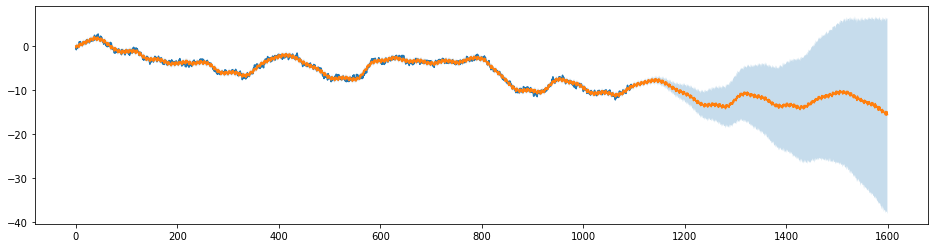

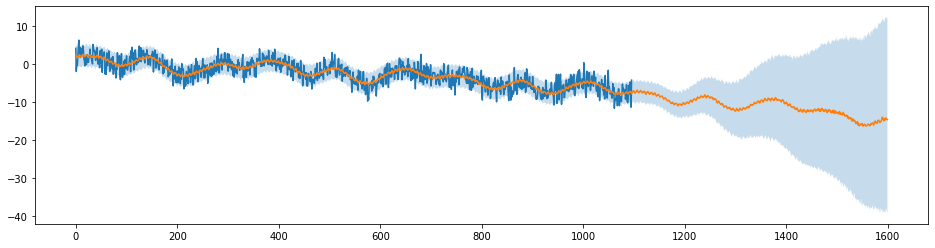

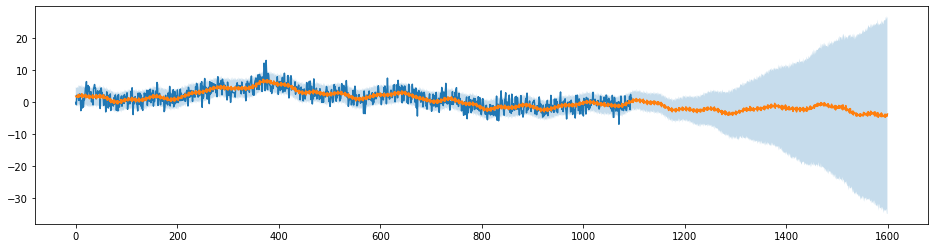

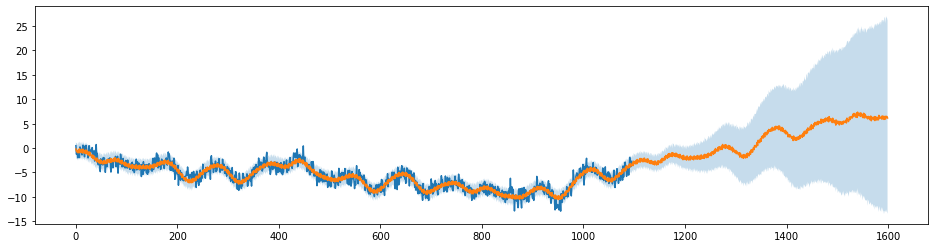

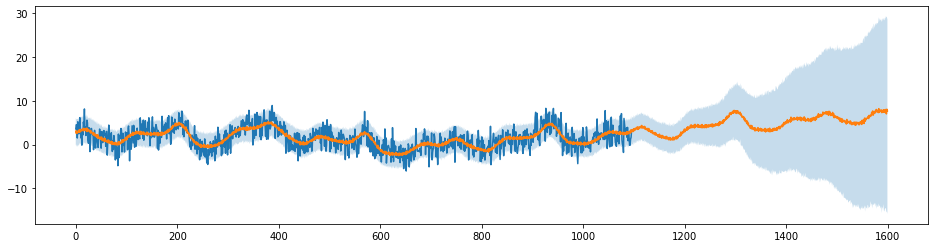

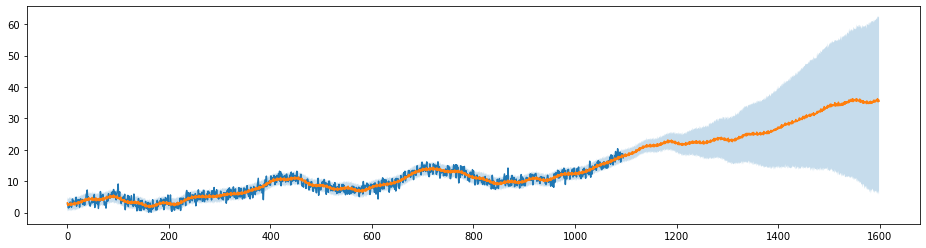

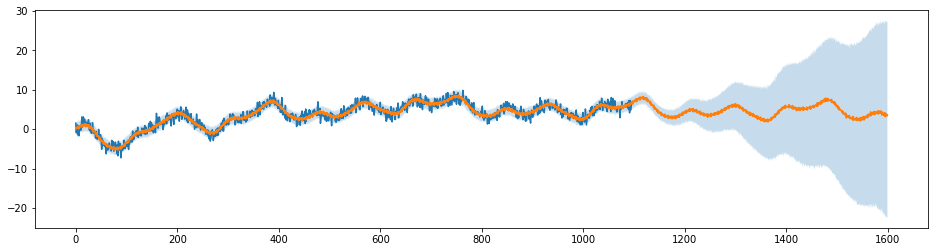

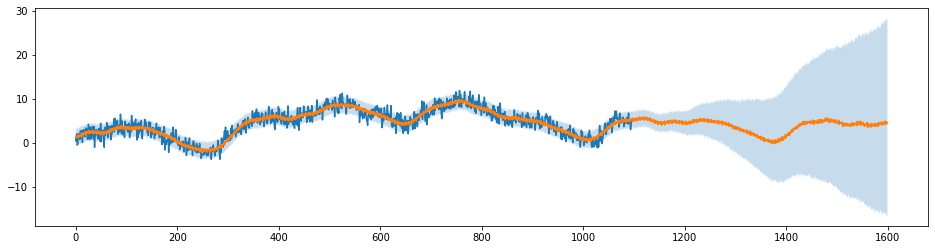

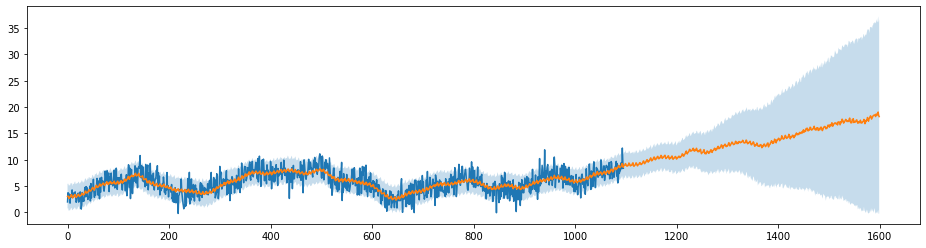

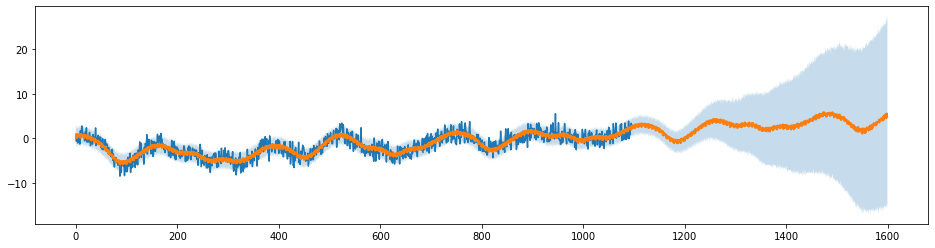

In [23]:
for idx_series in range(n_series):
    
    plt.figure(figsize=(16, 4))
    plt.plot(df['t'][:n_plot], df.iloc[:n_plot, idx_series + 1])
    plt.plot(df_fit['t'][:n_plot], quantiles[1, :n_plot, idx_series])
    plt.fill_between(df_fit['t'][:n_plot], quantiles[0, :n_plot, idx_series], quantiles[2, :n_plot, idx_series], alpha=0.25)
    plt.show()